<a href="https://colab.research.google.com/github/jimmy93029/Nanshan_tomb_image_segmentation/blob/main/yolo_nas_plus_SAM_(part2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## initialize

In [ ]:
!pip install -q super-gradients==3.1.3
!pip install -q roboflow
!pip install -q supervision

## Load trained model

In [ ]:
best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    checkpoint_path=f"{CHECKPOINT_DIR}/{EXPERIMENT_NAME}/average_model.pth"
).to(DEVICE)

 (deflated 8%)
  adding: content/checkpoints/football_players_detection/events.out.tfevents.1691200393.7fa31acaa435.1248.1 (deflated 45%)


## Evaluate trained model

In [ ]:
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )
)

[2023-08-05 01:55:37] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/football_players_detection/average_model.pth EMA checkpoint.
Testing: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

{'PPYoloELoss/loss_cls': 0.65019757,
 'PPYoloELoss/loss_iou': 0.17898679,
 'PPYoloELoss/loss_dfl': 0.5778513,
 'PPYoloELoss/loss': 1.3865902,
 'Precision@0.50': 0.16756877303123474,
 'Recall@0.50': 0.7925475835800171,
 'mAP@0.50': 0.7356501817703247,
 'F1@0.50': 0.25185179710388184}

### Inference with trained model

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml",
    force_masks=False
)

In [ ]:
import supervision as sv

CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

[2023-08-05 02:58:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-08-05 02:58:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-08-05 02:58:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-08-05 02:58:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-08-05 02:58:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-08-05 02:58:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-08-05 02:58:12] INFO -

### Visualize inference results

In [ ]:
import random
random.seed(10)

[2023-08-05 02:58:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


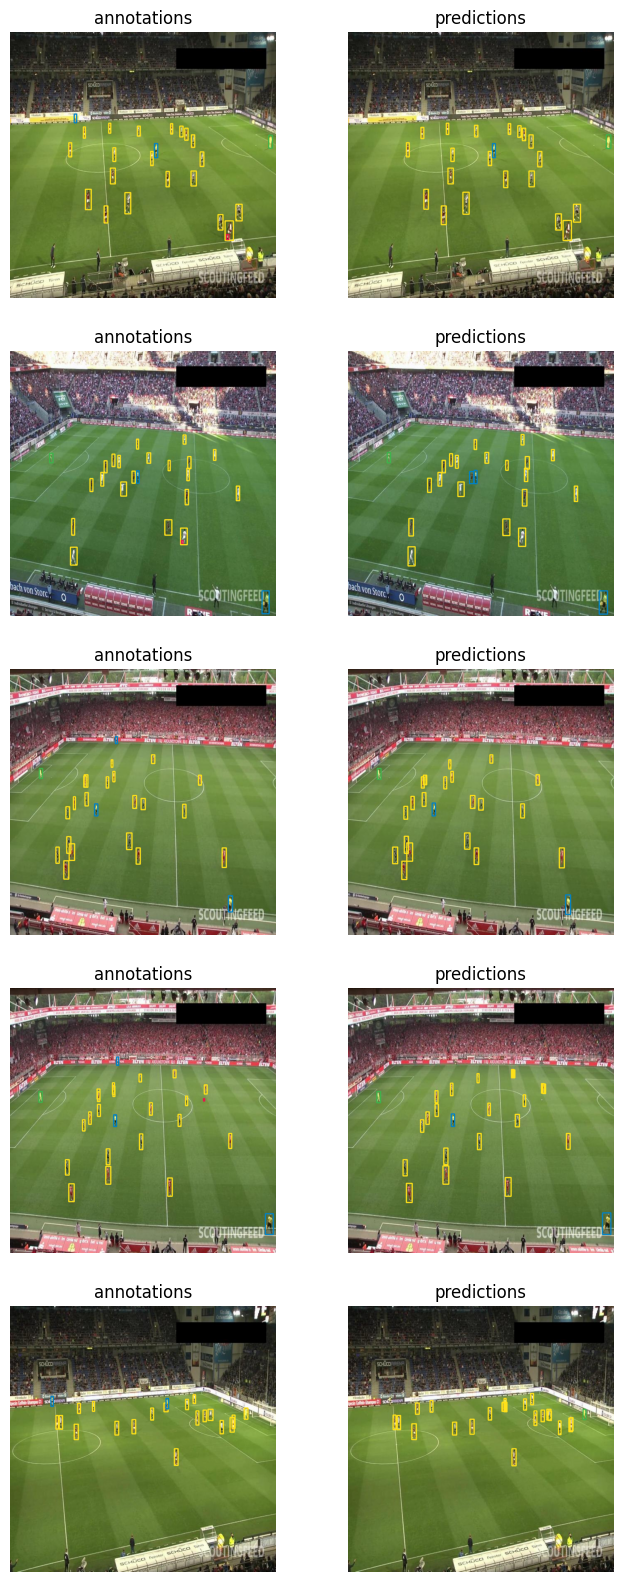

In [ ]:
MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))

### incorperate samgeo to make mask  
my innovation

In [ ]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-m7klhptw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-m7klhptw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [ ]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [ ]:
import os

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

In [ ]:
SAM_ENCODER_VERSION = "vit_h"

from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)


/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

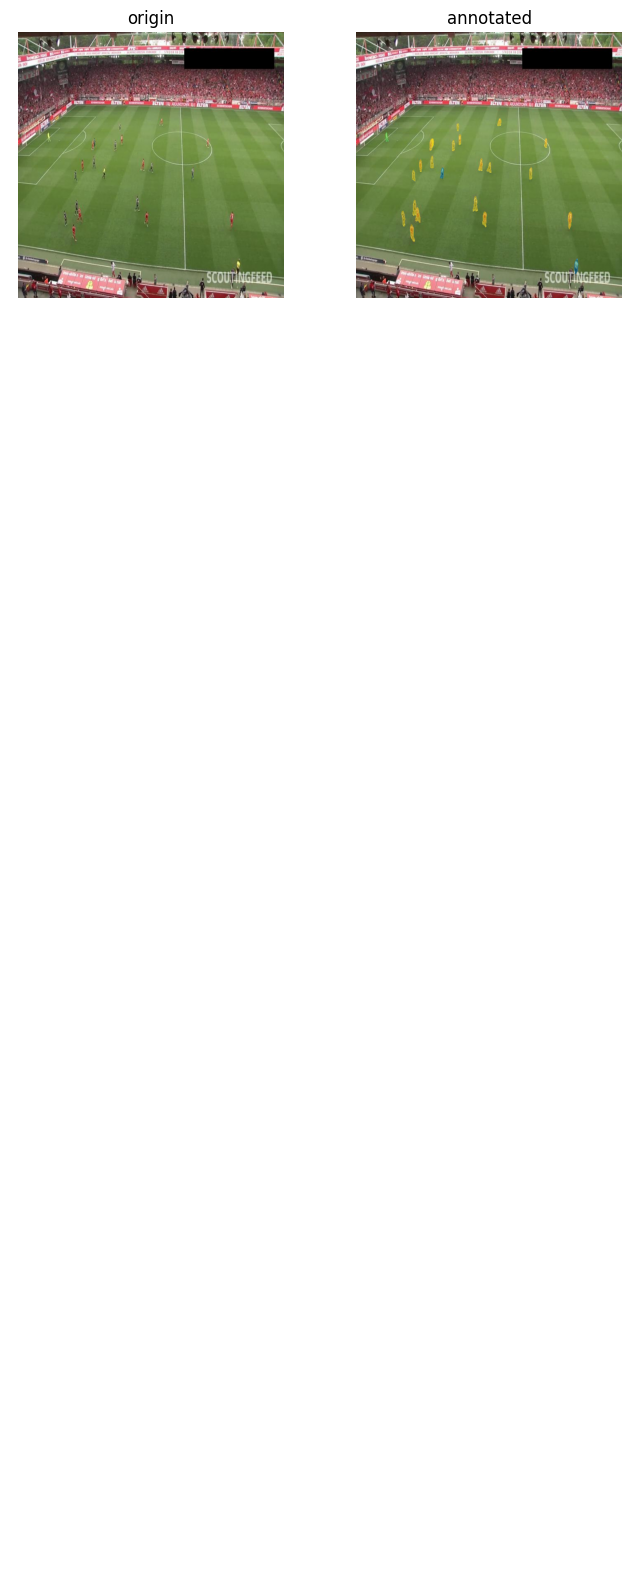

In [ ]:
%matplotlib inline

box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

key = keys[2]

# print(ds.annotations[key])
predictions[key].mask = segment(
            sam_predictor=sam_predictor,
            image=ds.images[key].copy(),
            xyxy=predictions[key].xyxy)

annotated_image = mask_annotator.annotate(scene=ds.images[key].copy(), detections=predictions[key])
# annotated_image = box_annotator.annotate(scene=ds.images[key].copy(), detections=predictions[key])

images = [ds.images[key].copy(), annotated_image]
titles = ["origin", "annotated"]

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))
# sv.plot_image(ds.images[key].copy(), (16, 16))
# sv.plot_image(annotated_image, (16, 16))